In [1]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/grad/lista 1')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 329 (delta 44), reused 40 (delta 40), pack-reused 280 (from 1)
Receiving objects: 100% (329/329), 4.02 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (128/128), done.


# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Aluno: Felipe Luz Machado

Base de dados:  Diabetes

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<b> Importante: </b> faça uma média dos resultados para cada item. Como o modelo é estocástico, os resultados podem variar de acordo com a inicialização dos pesos.

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [3]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar
  o mesmo modelo com apenas uma linha.

  Parâmetros de entrada:
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida.
  - hidden_activation: Função de ativação para cada camada escondida. Aceita
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]

    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [5]:
dataset_name = 'diabetes'
dataset_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [6]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [7]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [8]:
for i in dataset.dtypes.items():
    print(i)

('preg', dtype('int64'))
('plas', dtype('int64'))
('pres', dtype('int64'))
('skin', dtype('int64'))
('insu', dtype('int64'))
('mass', dtype('float64'))
('pedi', dtype('float64'))
('age', dtype('int64'))
('target', dtype('O'))


## Parte I - Compreensão do problema e análise de variáveis

Total: 1,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [24]:
print(dataset['skin'].value_counts()[0])
print(dataset['insu'].value_counts()[0])
print(dataset['pres'].value_counts()[0])


227
374
35


#### Resposta

In [27]:
print("zeros skin:", dataset['skin'].value_counts()[0])
print("zeros insu:", dataset['insu'].value_counts()[0])
#Pelo grande numero de zeros, que indica que não houve medição, as variaveis skin e insu sao candidatas imediatas a serem removidas do dataset

zeros skin: 227
zeros insu: 374


### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

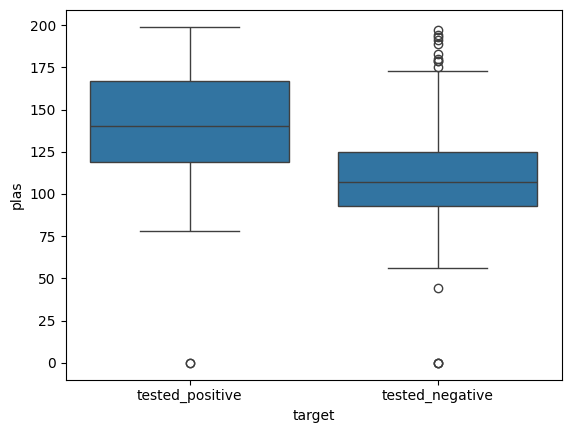

In [30]:
#dataset.hist(bins=30, figsize=(12,8))
#plt.show()
sns.boxplot(x="target", y="plas", data=dataset)
plt.show()


#### Resposta

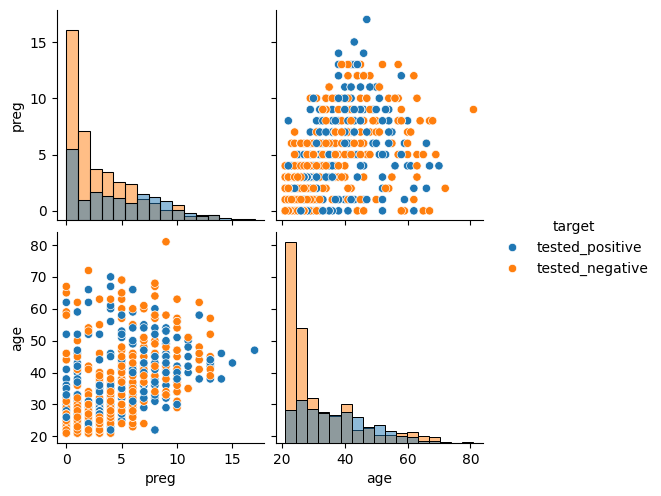

In [42]:
#sns.pairplot(dataset, hue="target", diag_kind="hist")
sns.pairplot(dataset[['preg','age','target']], hue="target", diag_kind="hist")




## Parte II. Treinamento do modelo de Rede Neural - Baseline

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [62]:
new_df = transform_data(dataset, normalize=False)
new_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,target,target_encoded
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,0
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,0
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1


In [52]:
new_df.head()

#removendo a coluna target original que continha strings
new_df = new_df.drop(columns=["target"])

In [53]:

print(new_df.columns)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Index(['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age',
       'target_encoded'],
      dtype='object')
Binary classification


In [54]:
batch_size = 32
epochs = 170

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



In [56]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [57]:
train_dataset.X_data

tensor([[  3.0000, 128.0000,  78.0000,  ...,  21.1000,   0.2680,  55.0000],
        [  4.0000,  95.0000,  60.0000,  ...,  35.4000,   0.2840,  28.0000],
        [  1.0000, 163.0000,  72.0000,  ...,  39.0000,   1.2220,  33.0000],
        ...,
        [  2.0000,  90.0000,  68.0000,  ...,  38.2000,   0.5030,  27.0000],
        [  5.0000, 116.0000,  74.0000,  ...,  32.3000,   0.6600,  35.0000],
        [  4.0000, 116.0000,  72.0000,  ...,  22.1000,   0.4630,  37.0000]])

In [58]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [59]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.287 | Val Loss: 0.8019 | Train Acc: 59.6875| Val Acc: 46.0000
Epoch 002: | Train Loss: 0.662 | Val Loss: 0.7051 | Train Acc: 63.6875| Val Acc: 54.0000
Epoch 003: | Train Loss: 0.641 | Val Loss: 0.6779 | Train Acc: 64.5625| Val Acc: 56.0000
Epoch 004: | Train Loss: 0.624 | Val Loss: 0.6858 | Train Acc: 65.0625| Val Acc: 55.0000
Epoch 005: | Train Loss: 0.623 | Val Loss: 0.6793 | Train Acc: 66.0625| Val Acc: 58.0000
Epoch 006: | Train Loss: 0.618 | Val Loss: 0.6792 | Train Acc: 66.5000| Val Acc: 59.0000
Epoch 007: | Train Loss: 0.615 | Val Loss: 0.7325 | Train Acc: 66.6875| Val Acc: 63.0000
Epoch 008: | Train Loss: 0.619 | Val Loss: 0.7086 | Train Acc: 67.0625| Val Acc: 63.0000
Epoch 009: | Train Loss: 0.616 | Val Loss: 0.7021 | Train Acc: 67.2500| Val Acc: 63.0000
Epoch 010: | Train Loss: 0.614 | Val Loss: 0.7003 | Train Acc: 67.2500| Val Acc: 64.0000
Epoch 011: | Train Loss: 0.613 | Val Loss: 0.6991 | Train Acc: 67.6875| Val Acc: 63.0000
Epoch 012: | Train Lo

In [60]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

              precision    recall  f1-score   support

           0       0.69      0.91      0.79        99
           1       0.62      0.27      0.38        55

    accuracy                           0.68       154
   macro avg       0.66      0.59      0.58       154
weighted avg       0.67      0.68      0.64       154



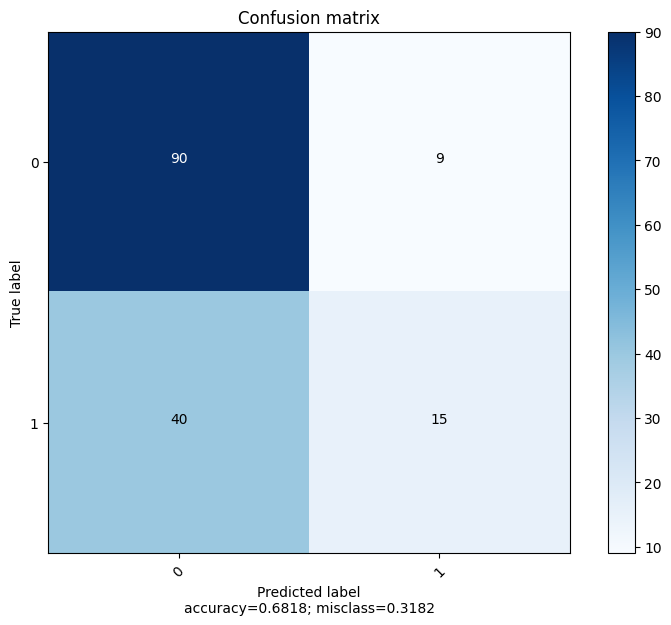

In [61]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

## Parte III - Mudança de configurações do modelo

Total: 8,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [65]:
new_df = transform_data(dataset, normalize=True)
new_df = new_df.drop(columns=['target'])
new_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,target_encoded
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1.0


In [66]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [67]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [68]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.727 | Val Loss: 0.7239 | Train Acc: 34.4375| Val Acc: 34.0000
Epoch 002: | Train Loss: 0.720 | Val Loss: 0.7173 | Train Acc: 34.4375| Val Acc: 34.0000
Epoch 003: | Train Loss: 0.714 | Val Loss: 0.7113 | Train Acc: 34.4375| Val Acc: 34.0000
Epoch 004: | Train Loss: 0.709 | Val Loss: 0.7058 | Train Acc: 34.4375| Val Acc: 34.0000
Epoch 005: | Train Loss: 0.703 | Val Loss: 0.7008 | Train Acc: 34.4375| Val Acc: 34.0000
Epoch 006: | Train Loss: 0.699 | Val Loss: 0.6962 | Train Acc: 34.4375| Val Acc: 33.0000
Epoch 007: | Train Loss: 0.694 | Val Loss: 0.6920 | Train Acc: 42.5625| Val Acc: 66.0000
Epoch 008: | Train Loss: 0.691 | Val Loss: 0.6881 | Train Acc: 65.5625| Val Acc: 66.0000
Epoch 009: | Train Loss: 0.687 | Val Loss: 0.6846 | Train Acc: 65.5625| Val Acc: 66.0000
Epoch 010: | Train Loss: 0.684 | Val Loss: 0.6813 | Train Acc: 65.5625| Val Acc: 66.0000
Epoch 011: | Train Loss: 0.681 | Val Loss: 0.6783 | Train Acc: 65.5625| Val Acc: 66.0000
Epoch 012: | Train Lo

#### Resposta

In [69]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        99
           1       0.00      0.00      0.00        55

    accuracy                           0.64       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.41      0.64      0.50       154



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


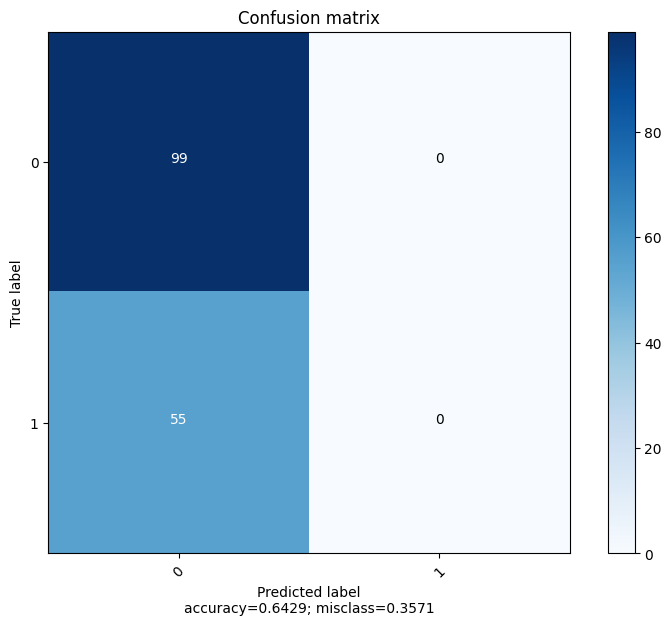

In [70]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

#### Resposta

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

#### Resposta

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

#### Resposta

## Parte IV - Análise dos resultados - **Extra**

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: crie uma nova função (e.g. train_EarlyStopping) ou use um parâmetro para habilitar/desabilitar o Early Stopping.

#### Rascunho

#### Resposta

### 2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco.

#### Rascunho

#### Resposta

### 3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada.

#### Rascunho

#### Resposta